# <h1><center>Proyecto final</center></h1>


## <h2><center>Cómputo conexionista (A21)</center></h2>

---

### <h3><center>

José Ángel Avelar Barragan (A200361)

José de Jesús Daniel Aguirre Arzate (A200350)
</center></h3>

---

## <center><h2>"Identification of patterns in cosmic-ray arrival directions using dynamic graph convolutional neural networks"</center></h2>

---

Como proyecto final nos propusimos intentar entender el articulo y tratar de replicar los resultados. A la par intentamos relacionar los conceptos vistos en clase con lo que hace el articulo. Como primer objetivo tuvimos que entender como se estan procesando los datos y como objetivo final intentar construir la red que ellos proponen (tensorflow/pytorch).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



<h2><center>Teoria</center></h2>

---

**Problema:**
A traves de los patrones en las direcciones de arrivo de las particulas, distingir rayos cosmicos que vienen de la misma fuente o de un fondo isotropico (ruido de fondo).

Este metodo intenta encontrar patrones en las direcciones de arrivo de rayos cosmicos, si existen patrones se calsifica a las particulas como las que vienen de una fuente comun y las que vienen de direcciones de arribo isotropicas.

Datos de entrenamiento: Simulaciones simples de direcciones de arribo donde se conoce la unica fuente que genera algunos rayos cosmicos(+ detalles en el articulo acerca de la configuracion del simulador BENCHMARK1)


<p align="center">
<img width="700" height="500" src="images/skymap_0.png">
</p>


In [ ]:
import numpy as np

import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

In [ ]:
#Intentando usar astrotools
try:
    import astrotools
    from astrotools import auger, coord, skymap
except ModuleNotFoundError: 
    print("Instalandolo entonces\n")
    !pip install healpy
    !pip install astrotools
from astrotools import skymap

<h2><center>Preparacion de datos</center></h2>

---

El dataset *dataset_HAP.npz* esta organizado de la siquiente manera:

Un diccionario con las keys: data, label
En las cuales en data esta un arreglo de 50000 simulaciones de 500 particulas cada una con sus respectivas coordenadas (x,y,z, E) donde E es la energia normalizada. 

Y el arreglo que viene en label clasifica a 1 como aaquellas simulaciones que tienen una fuente o 0 como aquellas que solo son arrivos isotropicos. 

In [ ]:
!ls "/content/drive/MyDrive/Proyecto/data/cosmic_ray_sphere" #Path de José Ángel

In [ ]:
dir ="/content/drive/MyDrive/Proyecto/data/cosmic_ray_sphere/"

In [ ]:
#Ruta de Jose para edgeConv.py
dir2 =  "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
def train_test_split():
    file = np.load("data/cosmic_ray_sphere/dataset_HAP.npz")
    x_train, x_test = file["data"][:-10000], file["data"][-10000:]
    labels = tf.keras.utils.to_categorical(file["label"],num_classes=2)
    y_train, y_test = labels[:-10000], labels[-10000:]
    return x_train, x_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split()
X_train.shape, X_test.shape

### test image

In [ ]:
test_id = 0
example_map = X_test[test_id]
skymap.eventmap(example_map[:,0:3].T, c=example_map[:,3], cblabel='Energy (normed)', opath="skymap_%i.png" % test_id)

In [ ]:
from PIL import Image
im = Image.open("skymap_0.png")
im

In [ ]:
train_points, test_points, train_features, test_features = X_train[...,:3], X_test[...,:3], X_train[...,-1, np.newaxis], X_test[...,-1, np.newaxis]
train_input_data, test_input_data = [train_points, train_features],[test_points, test_features]

### EdgeConv 
La convolución de aristas se basa en obtener caracteristicas invariantes a la permutación de la geometria local de un grafo, en lugar de obtenerlas de los embbedings del mismo. \
En particular se trata de un invariante al reordenamiento de los vecinos, ya que la función *construye* un grafo local y extrae los embedings de las aristas.

### K-nn
Para poder construir un grafo local se implementa el método de K-nn dónde el grafo generado depende del número de vecinos de cada nodo tales que estos sean los que están más cerca de este. \
En esta implementación se emplea el cálculo de la distancia euclideana entre los puntos y la misma capa convolucional realiza esta operación.

### $h_\Theta$ Función no lineal del mensaje

En este caso la función encargada de la no linealidad del mensaje es una MLP (detallada en arquitectura), esta también cumple con ajustar el tamaño del mensaje modificando así el número de caracteristicas asociados a cada nodo por capa de edgeConv. 

$$ h_{\theta} (x_{i,c},x_{i_j,c})= NN_\theta ( x_{i,c} , x_{i,c} - x_{i_j,c} )$$


### Agregación

La agregación del mensaje se hace por cada vecino que nos devuelve un mensaje, siendo descrita como:

$$ x_{i,c}' = \frac{1}{k_n} \sum \ h_{\theta}(x_{i,c},x_{i_j,c})$$

Notemos que este paso incluye al nodo central como parte del mensaje  *self-loop* pero concatena las caracteristicas del nodo con las caracteristicas de arista para obtener un nuevo vector enriquesido de caracteristicas que pasaran a la siguiente capa.


### Dynamic Graph

Se considera que la implementación es un gráfo dinámico ya que tras cada iteración se extiende el vector de coordenadas con las caracteristicas obtenidas por la capa previa, de forma que el k-nn formado por cada capa difiere del anterior. \
Presumimos que aquellos más similares se aproximarán en cada iteración, como se ilustra en: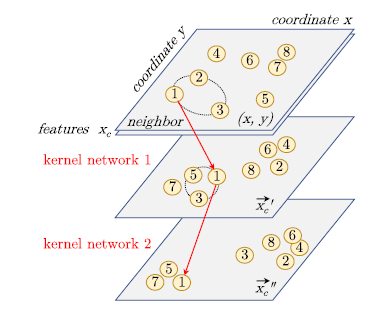


### Modelo completo
A continuación se declaran algunas de las caracteristicas y detalles de la arquitectura en cuestión:
- Separación de las entradas y aplicación de BatchNorm a las Caracteristicas (Energía)
- Incersión de las Coordenadas, concatenandolas con las caracteristicas antes de cada EdgeConv
- Aplicación de 3 EdgeConv, con unidades ReLU, 16 vecinos y  16,32 y 64 nodos en sus capas Densas respectivamente.
- GlobalAveragePooling, para emplear capas Densas
- Dos capas densas de 256 y 2 unidades con ReLU y SoftMax como activación.
- BatchNorm con momento 0.9 y $\epsilon \ 10^{-5}$
- Optimizador Adam, con Lr variable (decaimiento de $10^{-3}$ a $10^{-5}$ y decaimiento coseno)
- Metricas: Entropía Cruzada Categorica y Presición

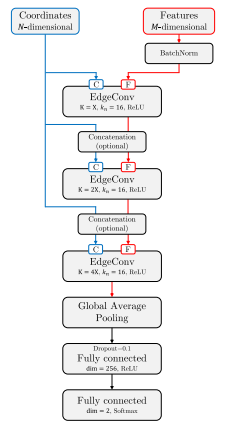
 

<h2><center>Implementacion</center></h2>

---

 
- <h3>Tensorflow</h3>

In [ ]:
MODEL = tf.keras.models.Model
LAYERS = tf.keras.layers
NODES = 16

def kernel_nn(data, nodes=NODES):
    d1, d2 = data

    delta = LAYERS.Subtract()([d1,d2])
    x = LAYERS.Concatenate(axis=-1)([d1,delta])

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)
    return x  

from edgeConv import EdgeConv
class DGCNN(MODEL):

    def __init__(self):
        super(DGCNN, self).__init__()

        self.HL1 = EdgeConv(lambda a: kernel_nn(a,nodes=8), next_neighbors=5)
        self.HL2 = EdgeConv(lambda a: kernel_nn(a,nodes=16), next_neighbors=8)
        self.HL3 = EdgeConv(lambda a: kernel_nn(a,nodes=32), next_neighbors=16)
        self.out = LAYERS.Dense(2, activation="softmax")
        self.ReLu = LAYERS.Activation("relu")
        
        self.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(3E-3, decay=1E-4),metrics=['acc'])
    
    def call(self,train_arr):
        points_in, feats_in = train_arr

        l1 = self.HL1([points_in, feats_in]) # (None, 500, 8) 
        l1 = self.ReLu(l1)

        l2 = self.HL2([points_in, l1]) # (None, 500, 16) 
        l2 = self.ReLu(l2)

        l3 = self.HL3([points_in, l2]) # (None, 500, 32) 
        l3 = self.ReLu(l3)
        l3 = LAYERS.GlobalAveragePooling1D(data_format='channels_first')(l3)

        out = self.out(l3) # (None, 2) 
        return out

points_in, feats_in= LAYERS.Input((500,3)), LAYERS.Input((500,1))
model.build([points_in.shape, feats_in.shape])
model.summary()


In [ ]:
BATCH_SIZE = 64
EPOCHS = 10
hist = model.fit(train_input_data, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
def plot_hist(history):
    fig, axes = plt.subplots(2, figsize=(12,8))
    if type(history) == dict:
        loss = history["loss"]
        acc = history["acc"]
    else:
        loss, acc = np.split(np.array(history), 2, axis=-1)
    x = np.arange(len(loss))
    axes[0].plot(x, loss, c="navy")
    axes[0].set_yscale("log")
    axes[0].set_ylabel("Loss")
    axes[1].plot(x, acc, c="firebrick")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1)
    if type(history) == dict:
        axes[0].set_xlabel("Epochs")
        axes[1].set_xlabel("Epochs")
    else:
        axes[0].set_xlabel("Iterations")
        axes[1].set_xlabel("Iterations")
    fig.tight_layout()
    return fig

In [ ]:
fig = plot_hist(hist.history)
fig.savefig("./history.png")